<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/NN_Weight_Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# dataset build

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-08 17:09:25--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-08 17:09:25--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  11.0MB/s    in 3.0s    

2021-03-08 17:09:29 (11.0 MB/s) - ‘MNIST.tar.gz’ saved [34813078]



In [ ]:
!tar -xf MNIST.tar.gz


In [ ]:
!ls MNIST/processed/

test.pt  training.pt


In [ ]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [ ]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

In [ ]:
train_classes

tensor([[0, 3],
        [2, 5],
        [5, 9],
        ...,
        [3, 5],
        [6, 5],
        [9, 5]])

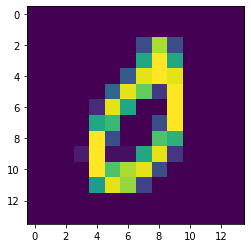

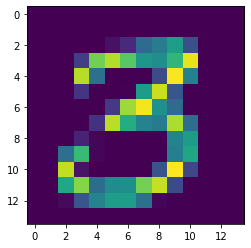

train shape : torch.Size([1000, 2, 14, 14])


In [ ]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [ ]:
# Divide datasets in batchs
# train_input     : N x 2 x 14 x 14 Images
# train_target    : N               Class to predict e {0,1}
# train_classes   : N x 2           Classes of the two digits e {0...9}

batch_size = 100
train_dataset = TensorDataset(train_input, train_target, train_classes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(test_input,test_target, test_classes)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
for el in train_dataloader:
  # image , target, classes
  print(el[0].shape, el[1].shape, el[2].shape)
  break

torch.Size([100, 2, 14, 14]) torch.Size([100]) torch.Size([100, 2])


# Train tools

In [ ]:
def train_epoch(network_ , optimizer_ , criterion = F.binary_cross_entropy ):
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data).flatten()
    loss = criterion(output, target.to(torch.float32))
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( (target == torch.round(output) ).sum().item() )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [ ]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += criterion_(output.flatten(), target.to(torch.float32)).item()
      acc += (target == torch.round(output.flatten()) ).sum().item()

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [ ]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, train_loss , train_acc , test_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

## Base CNN

In [ ]:
# train_input, train_target, train_classes, test_input, test_target, test_classes
train_input.shape

torch.Size([1000, 2, 14, 14])

In [ ]:
train_target.shape

torch.Size([1000])

In [ ]:
class CNN(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 200, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(200*4*4, 100)
        self.fc2 = nn.Linear(100, 100)

  def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=None, padding=0))
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 1))
        print(x.shape)
        x = x.view( batch_size,-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) 
        return F.log_softmax(x)
    
network = CNN()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

In [ ]:
next(enumerate(train_dataloader))[1][0].shape  # Image 100x2x14x14            train_input
next(enumerate(train_dataloader))[1][1]  # 100x1 Binary Value e (1,0)           train_target
next(enumerate(train_dataloader))[1][2].shape # pairs 100x2    e (0..9)x(0..9)  train_classes

torch.Size([100, 2])

In [ ]:
train_input.shape

torch.Size([1000, 2, 14, 14])

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (train_input, train_target, train_classes) in enumerate(train_dataloader):
    optimizer.zero_grad()
    output = network(train_input)
    #print(train_target.shape)
    #print(output.shape)
    loss = F.nll_loss(output, train_target)
    loss.backward()
    optimizer.step()


for epoch in range(1, 3):
  train(epoch)

torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
torch.Size([100, 200, 4, 4])
torch.Size([100, 20, 6, 6])
tor

## Weight Sharing CNN